# Modelo de regresión para la predicción de precios de automóviles
## Data science essential training
### DiplomadosOnline.com

Ejecute las siguientes lineas para continuar.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [5]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [6]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [7]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

## 3) Resultados

Ahora tenemos una función para entrenar un modelo de regresión lineal a nuestra a nuestra disposición, ası́ que vamos a utilizarla para construir una solución básica simple.

### 3.1 Solución básica simple

Sin embargo, para poder utilizarlo, necesitamos tener algunos datos: una matriz $X$ y un vector con $y$.

Ya hemos preparado la $y$, pero todavía no tenemos la $X$: lo que tenemos ahora mismo es un dataframe, no una matriz.

Ası́ que tenemos que extraer algunas caracterı́sticas de nuestro conjunto de datos para crear esta matriz $X$.

Empezaremos con una forma muy ingenua de crear caracterı́sticas: seleccionaremos algunas caracterı́sticas numéricas y formaremos la matriz $X$ a partir de ellas.

Incluimos las siguientes caracterı́sticas:

- motor cv (engine hp)

- cilindros del motor (engine cylinders)

- consumo en carretera (highway mpg)

- consumo en ciudad (city mpg)

- popularidad (popularity)

In [8]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

y luego para los valores faltantes:

In [9]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

**Entrenamiento:**

Explique cuál es el tratamiento aplicado, en este caso, a los valores faltantes (esto se desprende del código)

Ahora, aplicamos la función de preparación anterior a los datos de prueba df train y lo guardamos en una matriz llamada $X\_train$, es decir, 

In [12]:
X_train = prepare_X(df_train)

La matriz $X\_train$ la usamos como input en nuestro modelo, a través de la función train linear regression que hemos creado, es decir,

In [13]:
b_0, b = train_linear_regression(X_train, y_train)

**Entrenamiento**

Imprima los valores de $\beta$ y $\beta_{0}$ ¿Qué observa?

Acabamos de entrenar el primer modelo. Ahora podemos aplicarlo a los datos de entrenamiento para ver que tan bien predice:

In [14]:
y_pred = b_0 + X_train.dot(b)

Ploteamos los valores predichos y los precios reales,

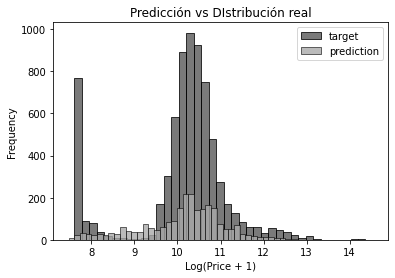

In [25]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predicción vs DIstribución real')

plt.show()

**Entrenamiento:**

Describa cada linea del código.

¿Qué finalidad tiene la realización de este plot?

¿Qué puede concluir del gráfico?

### 3.2 RMSE

Ahora, necesitamos una métrica que cuantifique la calidad del modelo.

La más utilizada es el **error cuadrático medio (RMSE)**.

El RMSE nos indica la magnitud de los errores que comete nuestro modelo. Se calcula con la siguiente fórmula:

$RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(f(x_{i})-y_{i})^{2}}$,

 es decir, 

In [19]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

**Entrenamiento**

- Aplique la función creada a los vectores $y\_train$, $y\_pred$. ¿Qué puede decir del resultado?

### 3.3 Validación del modelo

Hemos calculado el **RMSE** en el conjunto de entrenamiento. El resultado es útil de conocer, pero no refleja la forma en que se utilizará el modelo posteriormente.

El modelo se utilizará para predecir el precio de los autos que no ha visto antes. Para ello, reservamos un conjunto de validación.

Ya hemos dividido nuestros datos en varias partes: $df\_train$ , $df\_val$ , y $df\_test$ .

También hemos creado una matriz $X\_train$ a partir de $df\_train$ y hemos utilizado $X\_train$ e $y\_train$ para entrenar el modelo.

Ahora tenemos que hacer los mismos pasos para obtener $X\_val$ (una matriz con caracterśticas calculadas a partir del conjunto de datos de validación).

Luego, podemos aplicar el modelo a $X\_val$ para obtener predicciones y compararlas con $y\_val$

In [20]:
X_val = prepare_X(df_val)
y_pred = b_0 + X_val.dot(b)

In [21]:
rmse(y_val, y_pred)

0.7616530991301607

**Entrenamento:**

¿Qué puede concluir? ¿Hay una mejora?

### Ingeniería de características simples

Ya tenemos un modelo de referencia sencillo con características simples. Para mejorar nuestro modelo podemos añadir más características al modelo: creamos otras y las añadimos a las características existentes. 

Este proceso se denomina **ingeniería de características**.

Como ya hemos creado el marco de validación, podemos comprobar fácilmente si la adición de nuevas características mejora la calidad del modelo. 

Nuestro objetivo **es mejorar el RMSE calculado sobre los datos de validación**.

En primer lugar, creamos una nueva característica, "`edad`", a partir de la característica "`year`". 

La edad de un auto debería ser muy útil para predecir su precio: intuitivamente, cuanto más nuevo sea el coche, más caro debería ser.

Dado que el conjunto de datos se creó en 2017 (lo que podemos verificar comprobando `df_train.year.max()` ), podemos calcular la edad restando el año en que se fabricó el auto de 2017.

Ya sabemos que tendremos que aplicar el mismo preprocesamiento dos veces: a los conjuntos de entrenamiento y de validación. 

Como no queremos repetir el código de extracción de características múltiples veces, vamos a poner esta lógica en la función `prepare_X`.


In [22]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['edad'] = 2017 - df.year
    features.append('edad')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

**Entrenamiento**

¿Qué hacemos en cada linea del código?

Probemos si la adición de la característica "`edad`" conlleva alguna mejora:

In [24]:
X_train = prepare_X(df_train)
b_0, b = train_linear_regression(X_train, y_train)

y_pred = b_0 + X_train.dot(b)
print('Entrenamiento:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = b_0 + X_val.dot(b)
print('validación:', rmse(y_val, y_pred))

Entrenamiento: 0.5175055465840046
validación: 0.5172055461058338


El error de validación es de $0,517$, lo que supone una buena mejora con respecto a $0,76$, el valor que teníamos en la solución de referencia.

Por tanto, concluimos que añadir la "`edad`" es realmente útil a la hora de hacer predicciones.

También podemos observar la distribución de los valores predichos:

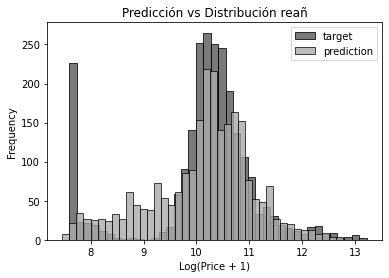

In [26]:
plt.figure(figsize=(6, 4))


sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predicción vs Distribución reañ')

plt.show()

### Manejo de variables categóricas

Vemos que añadir "`edad`" es bastante útil para el modelo. Sigamos añadiendo más características. Una de las columnas que podemos utilizar a continuación es el número de puertas. 

Esta variable parece ser numérica y puede tomar tres valores: 2, 3 y 4 puertas. 

Aunque es tentador poner la variable en el modelo tal cual, no es realmente una variable numérica: no podemos decir que al añadir una puerta más, el precio de un auto crece (o baja) en una determinada cantidad de dinero.La variable es más bien categórica. 

Podemos utilizar las variables categóricas en un modelo de múltiples maneras. Una de las formas más sencillas es codificar dichas variables mediante un conjunto de características binarias, con una característica separada para cada valor distinto.

En nuestro caso, crearemos tres características binarias: `num_puertas_2` , `num_puertas_3` , y `num_puertas_4` . Si el auto tiene dos puertas, `num_doors_2` será 1 y el resto será 0, y así sucesivamente.

Este método de codificación de variables categóricas se denomina **one-hot encoding**.



In [32]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['edad'] = 2017 - df.year
    features.append('edad')

    for v in [2, 3, 4]:
        feature = 'num_puertas_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

**Entrenamiento**

¿Qué hacemos en cada linea del código?


Comprobemos si este código mejora el RMSE del modelo:

In [33]:
X_train = prepare_X(df_train)
b_0, b = train_linear_regression(X_train, y_train)

y_pred = b_0 + X_train.dot(b)
print('Entrenamiento :', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = b_0 + X_val.dot(b)
print('Validación:', rmse(y_val, y_pred))

Entrenamiento : 0.5058876515487503
Validación: 0.50760388495572


El valor anterior era de $0,517$, por lo que conseguimos mejorar aún más la puntuación del RMSE.

Podemos utilizar algunas variables más: `engine_fuel_type` , `transmission_type` , `driven_ wheels` , `market_category` , `vehicle_size` , y `vehicle_style` . 

Hagamos lo mismo para ellos. Después de las modificaciones, `prepare_X` empieza a ser un poco más complejo.

**Entrenamiento**

Agregue cada una de as transformaciones de forma secuencial, y mida en cada paso la puntuación `RMSE`.¿Qué observa?

Ahora, hacemos las transformación con todas las variables, es decir,

In [34]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['edad'] = 2017 - df.year
    features.append('edad')
    
    for v in [2, 3, 4]:
        feature = 'num_puertas_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'es_construido_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in ['regular_unleaded', 'premium_unleaded_(required)', 
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'es_tipo_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'es_transmision_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'es_driven_wheens_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'es_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'es_estilo_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

Verifiquemos si mejora el modelo con estas características,

In [35]:
X_train = prepare_X(df_train)
b_0, b = train_linear_regression(X_train, y_train)

y_pred = b_0 + X_train.dot(b)
print('Entrenamiento:', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = b_0 + X_val.dot(b)
print('Validacion:', rmse(y_val, y_pred))

Entrenamiento: 75.06709580876142
Validacion: 36.955146915047585


El número que vemos es significativamente peor que antes. Obtenemos $36,9$, que es mucho más que el $0,5$ que teníamos antes.

En lugar de ayudar, las nuevas características empeoraron mucho el resultado. 

Por suerte, disponemos de la validación que nos ayudan a detectar este problema. 

### Regularización

Hemos visto que añadir nuevas características no siempre ayuda, y en nuestro caso, hizo las cosas mucho peor. 

La razón de este comportamiento es la inestabilidad numérica.

Recordemos la fórmula de la ecuación normal:

$\beta = (X^{T}X)^{-1}X^{T}y$

La inversión es el problema en nuestro caso, $(X^{T}X)^{-1}$ . A veces, al añadir nuevas columnas a X, podemos añadir accidentalmente una columna que es una combinación de otras columnas.

Cuando esto ocurre, $(X^{T}X)^{-1}$ se vuelve indeterminada o singular, lo que significa que no es no es posible encontrar una inversa para esta matriz. 

Si intentamos invertir una matriz singular `NumPy` nos avisará de ello lanzando un `LinAlgError`.

En el álgebra lineal numérica, estos problemas se denominan **problemas de inestabilidad numérica**, y se suelen resolver con técnicas de regularización. 

El objetivo de la regularización es asegurarse que la inversa existe, forzando a la matriz a ser invertible. 

Una forma de hacer la regularización es añadir un pequeño número a cada elemento diagonal de la matriz. 

Entonces obtenemos la siguiente fórmula para la regresión lineal:

$\beta = (X^{T}X + r I)^{-1}X^{T}y$

Vamos a crear una nueva función que utilice esta idea e implemente la regresión lineal con regularización.

In [36]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [37]:
X_train = prepare_X(df_train)

Comprobemos qué ocurre con nuestras ponderaciones para diferentes valores de `r` :

In [38]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, -5225093807643363.00, 1.56, 5225093807640315.00
0.001, 7.20, -0.10, 1.81
 0.01, 7.18, -0.10, 1.81
  0.1, 7.05, -0.10, 1.78
    1, 6.22, -0.10, 1.56
   10, 4.39, -0.09, 1.08


Vemos que los valores que seleccionamos se hacen más pequeños a medida que `r` crece.

Ahora vamos a comprobar si la regularización ayuda a nuestro problema y qué RMSE obtenemos.

Vamos a ejecutarlo con $r=0.001$:

In [39]:
X_train = prepare_X(df_train)
b_0, b = train_linear_regression_reg(X_train, y_train, r=0.01)

y_pred = b_0 + X_train.dot(b)
print('Entrenamento', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = b_0 + X_val.dot(b)
print('Validación', rmse(y_val, y_pred))

Entrenamento 0.4643124894529771
Validación 0.46023949630305716


Este resultado supone una mejora respecto a la puntuación anterior: $0,507$.

### Utilización del modelo

Como ya tenemos un modelo, podemos empezar a utilizarlo para predecir el precio de un auto.

Supongamos que un usuario publica el siguiente anuncio en nuestro sitio web:

In [40]:
i = 2
ad = df_test.iloc[i].to_dict()
ad

{'city_mpg': 18,
 'driven_wheels': 'all_wheel_drive',
 'engine_cylinders': 6.0,
 'engine_fuel_type': 'regular_unleaded',
 'engine_hp': 268.0,
 'highway_mpg': 25,
 'make': 'toyota',
 'market_category': 'crossover,performance',
 'model': 'venza',
 'number_of_doors': 4.0,
 'popularity': 2031,
 'transmission_type': 'automatic',
 'vehicle_size': 'midsize',
 'vehicle_style': 'wagon',
 'year': 2013}

Nos gustaría sugerir el precio de este auto. Para ello, utilizamos nuestro modelo:

In [41]:
X_test = prepare_X(pd.DataFrame([ad]))[0]
y_pred = b_0 + X_test.dot(b)
suggestion = np.expm1(y_pred)
suggestion

28294.13588598235

La salida es de $28.294,13$. El precio real de este coche es de $31.120$ dólares, por lo que nuestro modelo no se aleja del precio real.